In [1]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from scipy.special import erf
import os
import pandas as pd
from typing import Union

def EFP(time: np.int32 | npt.NDArray[np.int32], amplitude: np.float64, mu: np.float64, sigma: np.float64, tau: np.float64, a: np.float64, background: np.float64) -> np.float64 | npt.NDArray[np.float64]:
    Aprime = amplitude * sigma / (tau * np.sqrt(2 / np.pi))
    y1 = -(time - mu) / tau + sigma**2 / (2 * tau**2)
    y2 = (time - mu) / (np.sqrt(2) * sigma) - sigma / (np.sqrt(2) * tau)
    return Aprime * np.exp(y1) * (1 + erf(y2)) + a * time + background

def plot_flare(identifier: str, pred=None, act=None, save_dir=None):
    dirname = ''
    datafile = f'{dirname}flares/{identifier}.csv'
    df = pd.read_csv(datafile)
    summaryfile = f'{dirname}allflares_preprocessed.csv'
    allcsv = pd.read_csv(summaryfile)
    row = allcsv[allcsv['identifier'] == identifier].iloc[0]

    fig, axs = plt.subplots(2, figsize=(9.6, 9.6), gridspec_kw={'height_ratios': [3, 1]})

    if act != None and pred != None:
        axs[0].set_title(f"{identifier}: pred: {pred}, actual: {act}")
    else:
        axs[0].set_title(f'{identifier}')
    plt.xlabel('Time (s)')
    plt.subplots_adjust(hspace=.0)
    linestyle = {"elinewidth":1, "capsize":0, "ecolor":"grey"}
    plt.setp(axs[0].get_xticklabels(), visible=False)

    xt = df['Time']
    yt = df['Counts']
    yerr = df['Error']

    axs[0].errorbar(xt, yt, yerr=yerr, fmt='D', ms=3, c='blue', **linestyle)

    for ax in axs:
        ax.tick_params(which='major', width=1)
        ax.tick_params(which='major', length=4)
        ax.margins(x=0)
    axs[0].set_ylabel('Flux (nW/m$^2$)')
    axs[1].set_ylabel('Residual ((o-f)/$\\sigma$)')
    axs[1].set_ylim(bottom=-4,top=4)

    range = (np.max(yt) - np.min(yt))/10
    axs[0].scatter(row['start_time'], \
        row['start_count'], c='k', s=30, zorder=15)
    axs[0].vlines(x=row['start_time'], \
        ymin=row['start_count'] - range, \
        ymax=row['end_count'] + range, color='k', linestyle='dotted', linewidth=2)
    axs[0].scatter(row['end_time'], \
        row['end_count'], c='k', s=30, zorder=15)
    axs[0].vlines(x=row['end_time'], \
        ymin=row['end_count'] - range, \
        ymax=row['end_count'] + range, color='k', linestyle='dotted', linewidth=2)

    yfit = EFP(xt, row['amplitude'], row['mu'], row['sigma'], row['tau'], 0, 0)
    axs[0].plot(xt, yfit, c='r', zorder=10, lw=3)
    axs[0].tick_params(axis='x', direction='in')
    axs[1].errorbar(xt, (yt-yfit)/np.std(yt-yfit), yerr=yerr/np.std(yt-yfit), fmt='D', ms=3, c='blue', **linestyle)
    axs[1].axhline(np.mean((yt-yfit)/np.std(yt-yfit)), linestyle='--', lw=1, c='navy')

    if save_dir != None:
        plt.savefig(save_dir)

    plt.show()

2187


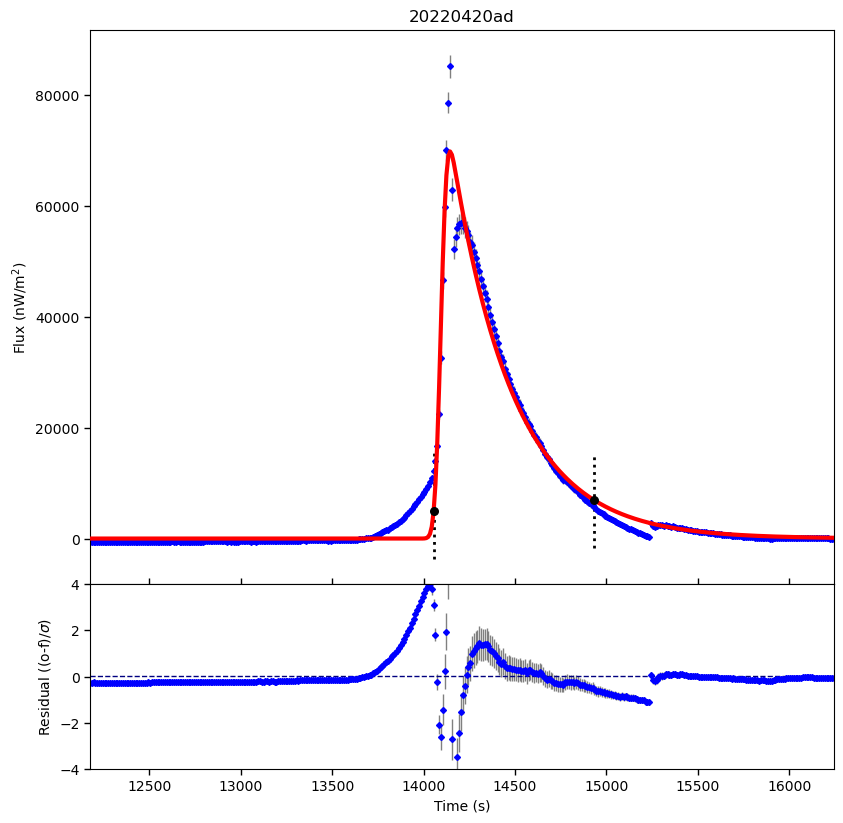

In [21]:
print(np.argmax(np.array(class_info['peak_count'])))

plot_flare('20220420ad')

In [2]:
import pandas as pd
from scipy.signal import welch
from scipy.optimize import curve_fit
from tqdm import tqdm

class_info = pd.read_csv('allflares_preprocessed.csv')

columns = np.concatenate((np.array(class_info.columns), ['slope']))

processed = pd.DataFrame(columns=columns)

print(processed)

tot_flares = 0
a_rsq = []
b_rsq = []

for i, iden in enumerate(tqdm(np.array(class_info['identifier']))):
    try:
        tod = pd.read_csv('flares/' + iden + '.csv')
    except FileNotFoundError:
        continue

    if np.max(np.diff(tod['Time'])) > 10:
        continue

    if class_info['peak_count'][i] < 50:
        continue

    if class_info['multi_flare_region_flag'][i] == True or class_info['region_resolved_flag'][i] == False:
        continue

    if class_info['peak_time'][i] < class_info['start_time'][i] + 0.25*class_info['duration'][i] or class_info['peak_time'][i] > class_info['end_time'][i] - 0.25*class_info['duration'][i]:
        continue

    try:
        params, pcov = curve_fit(EFP, tod['Time'], tod['Counts'], p0=[class_info['amplitude'][i], class_info['mu'][i], class_info['sigma'][i], 
            class_info['tau'][i], 0, class_info['background'][i]], bounds=((0, -np.inf, -np.inf, -np.inf, -1, -np.inf), (1e5, np.inf, 
            np.inf, np.inf, 1, np.inf)), maxfev=100000)
    except Exception as e:
        print(e)
        continue

    x_data = np.array(tod['Time'])
    y_data = np.array(tod['Counts'])
    
    y_pred = EFP(x_data, *params)

    # Compute SST
    y_mean = np.mean(y_data)
    sst = np.sum((y_data - y_mean) * (y_data - y_mean))
    
    # Compute RSS
    rss = np.sum((y_data - y_pred) * (y_data - y_pred))
    
    # Compute R^2
    r_squared = 1 - (rss / sst)

    if r_squared < 0.8:
        continue

    if params[2]/params[3] < 2.65:
        flare_type = 'B'
        b_rsq.append(r_squared)
    else:
        flare_type = 'A'
        a_rsq.append(r_squared)

    tot_flares += 1

    new_row = pd.DataFrame([{'date': class_info['date'][i], 'identifier': class_info['identifier'][i], 'start_time': class_info['start_time'][i], 
                'start_count': class_info['start_count'][i], 'peak_time': class_info['peak_time'][i], 'peak_count': class_info['peak_count'][i],
                'end_time': class_info['end_time'][i], 'end_count': class_info['end_count'][i], 'scpeaks0-05': class_info['scpeaks0-05'][i], 
                'multi_flare_region_flag': class_info['multi_flare_region_flag'][i], 'region_resolved_flag': class_info['region_resolved_flag'][i],
                'flare_class': class_info['flare_class'][i], 'background': params[5], 'amplitude': params[0], 'mu': params[1], 'sigma': params[2], 
                'tau': params[3], 'redchisq': class_info['redchisq'][i], 'rsquared': r_squared, 'snr': class_info['snr'][i], 
                'fluence': class_info['fluence'][i], 'sigma-by-tau': params[2]/params[3], 'flare_type': flare_type, 
                'duration': class_info['duration'][i], 'slope': params[4]}])

    processed = pd.concat([processed, new_row], ignore_index=True)

    # flare_class, background, amplitude, mu, sigma, tau, redchisq, rsquared, snr, fluence, sigma-by-tau, flare_type, duration, slope

    #print(f"slope = {params[4]}, background = {params[5]}, amplitude = {params[0]}, sigma = {params[2]}, tau = {params[3]}")
    
    plt.scatter(tod['Time'], tod['Counts'])
    plt.plot(np.arange(np.min(tod['Time']), np.max(tod['Time'])), EFP(np.arange(np.min(tod['Time']), np.max(tod['Time'])), *params))

    plt.axvline(class_info['peak_time'][i], c='r', ls='--')

    plt.xlabel('Time (s)')
    plt.ylabel('Counts')

    plt.title(f"{iden}: $R^2 \\approx {np.round(r_squared, 3)}$, Type {flare_type}")

    plt.savefig(f'plots_strict/{iden}.png')

    plt.close()

    #plt.show()

print(tot_flares)
print(len(a_rsq))
print(len(b_rsq))

Empty DataFrame
Columns: [date, identifier, start_time, start_count, peak_time, peak_count, end_time, end_count, scpeaks0-05, multi_flare_region_flag, region_resolved_flag, flare_class, background, amplitude, mu, sigma, tau, redchisq, rsquared, snr, fluence, sigma-by-tau, flare_type, duration, slope]
Index: []

[0 rows x 25 columns]


  0%|                                                  | 0/8045 [00:00<?, ?it/s]/tmp/ipykernel_6027/1771607565.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed = pd.concat([processed, new_row], ignore_index=True)
 15%|█████▉                                 | 1228/8045 [00:19<02:22, 47.67it/s]/home/mrchu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 21%|████████                               | 1674/8045 [00:27<05:35, 19.01it/s]

`x0` is infeasible.


 23%|████████▌                             | 1817/8045 [00:28<00:43, 143.39it/s]/home/mrchu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 25%|█████████▊                             | 2025/8045 [00:30<01:22, 73.10it/s]

`x0` is infeasible.
`x0` is infeasible.


 27%|██████████▍                            | 2147/8045 [00:32<01:12, 81.38it/s]

`x0` is infeasible.


 28%|██████████▉                            | 2265/8045 [00:35<03:12, 29.95it/s]

`x0` is infeasible.


 34%|█████████████▍                         | 2762/8045 [00:58<01:17, 68.10it/s]/home/mrchu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 46%|█████████████████▌                    | 3722/8045 [01:06<00:13, 309.82it/s]/home/mrchu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 47%|█████████████████▊                    | 3763/8045 [01:07<00:30, 139.52it/s]/home/mrchu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 64%|████████████████████████▏             | 5116/8045 [01:13<00:26, 109.60it/s]/home/mrchu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(uf

`x0` is infeasible.


 86%|████████████████████████████████▋     | 6932/8045 [01:17<00:02, 460.60it/s]/home/mrchu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 87%|████████████████████████████████▉     | 6985/8045 [01:18<00:04, 252.42it/s]/home/mrchu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|███████████████████████████████████████| 8045/8045 [01:21<00:00, 99.12it/s]

404
82
322
